In [1]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics.pairwise import cosine_similarity

from urllib.parse import urljoin
import itertools
import random

import matplotlib.pyplot as plt
import networkx as nx

import igraph

In [2]:
ML_100k_BASE_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k/'

def movielens_url(fname):
    return urljoin(ML_100k_BASE_URL, fname)

In [3]:
rating_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

# TODO: read ratings from u.data
ratings = pd.read_csv(movielens_url('u.data'), sep='\t',names=rating_cols)

In [4]:
ratings.shape

(100000, 4)

### build utility matrix

In [5]:
def user_id_to_index(id):
    return id-1
#since user id start from 1 and index id start from 0
def user_index_to_id(idx):
    return idx+1

# Accounts for the bad movie
def movie_id_to_index(id):
    return id-1 
# since movie id start from 1 and index from 0
# Accounts for the bad movie
def movie_index_to_id(idx):
    return idx+1 

def mse_utility(u1, u2):
    return mse(u1[u1.nonzero()].flatten(), u2[u2.nonzero()].flatten())

In [6]:
userNums = ratings.user_id.unique().shape[0]
movieNums = ratings.movie_id.unique().shape[0]

In [7]:
%%time
utility = np.zeros((userNums, movieNums))

for idx,rating in ratings.iterrows():
    utility[user_id_to_index(rating.user_id), movie_id_to_index(rating.movie_id)] = rating.rating


CPU times: user 8.64 s, sys: 107 ms, total: 8.75 s
Wall time: 9.56 s


In [8]:
utility[0].max()

5.0

### Find the user-user matrix

In [9]:
def cosine_sim(v1, v2):
    numerator = 0
    denominator_A = 0
    denominator_B = 0
    for x,y in zip(v1,v2):
        numerator += x*y
        denominator_A += x**2
        denominator_B += y**2
    cos_distance = numerator/((denominator_A)**(1/2)*(denominator_B)**(1/2))

    return cos_distance


In [10]:
def sim_matrix(u, eps=1.0e-9):
    step1 = u.dot(u.T) + eps
    step2 = np.array([np.sqrt(np.diagonal(step1))])
    return (step1 / step2 / step2.T)


In [11]:
def sim_allpairs(u):
    n = u.shape[0]
    sim = np.eye(n)
    for x in itertools.combinations(range(n), 2):
        s = cosine_sim(u[x[0]], u[x[1]])
        sim[x[0], x[1]] = s
        sim[x[1], x[0]] = s
    
    return sim


In [12]:
def sim_users(u):
    return sim_matrix(u)

In [13]:
def top_k(arr, self_idx, k):
    k_nn = {}
    rank = np.argsort(-1*arr)
    mt_idx = np.argwhere(rank == self_idx)
    rank = np.delete(rank,mt_idx)
    for i in rank[:k]:
        k_nn[i] = arr[i]

    return k_nn

In [14]:
def rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k):
    k_weight = top_k(arr=m_sim_users[:,user_idx],self_idx=user_idx,k=k)
    nn = []
    weight = []
    for key,value in k_weight.items():
        nn.append(key)
        weight.append(value)
    weight = np.array(weight)
    scores = m_utility[nn][:,item_idx]
    weight = weight[np.nonzero(scores)]#get rid of the user who didnt rate
    scores = scores[np.nonzero(scores)]
    if len(weight) == 1: 
        return scores[0]
    else:
        if np.sum(weight) != 0: #why???? Why will we have divided 0 error????Why?????
            rec_score = (scores.T@weight)/np.sum(weight)
            return rec_score
        else:
            return 0


In [15]:
def recs_via_users(m_utility, m_sim_users, k, test_n):
    test = random.sample(range(m_sim_users.shape[0]), test_n)
    true = []
    pred = []
    for user_idx in test:
        for item_idx in range(m_utility.shape[1]):
            if m_utility[user_idx][item_idx] != 0:
                true.append(m_utility[user_idx][item_idx])
                #ground truth
                p = round(rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k))
                #prediction
                if p != 0:  #if we can predict.
                    pred.append(p) 
                else:
                    pred.append(1.0e-9)
                        

    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))


In [16]:
%%time
similarity_users = sim_users(utility)


CPU times: user 69.7 ms, sys: 11.6 ms, total: 81.3 ms
Wall time: 54.4 ms


In [17]:
similarity_users.shape

(943, 943)

In [18]:
ks = []
mses = []
for i in range(50):
    ks.append(i+1)
    mses.append(recs_via_users(utility, similarity_users, i+1, 100))
    print("{}/50".format(i+1), mses[-1])

1/50 5.985176546213524
2/50 3.8970862891350393
3/50 3.137886262184368
4/50 2.458079872310853
5/50 2.231733914307524
6/50 2.2113030951396686
7/50 1.887507768364379
8/50 1.8669716024072802
9/50 1.7415028473090208
10/50 1.8050062574881935
11/50 1.7017003079204533
12/50 1.5706111235639733
13/50 1.494422827264678
14/50 1.6887175658365248
15/50 1.5902808736094518
16/50 1.4030405403371622
17/50 1.3839895011275591
18/50 1.4156997822710298
19/50 1.3482029438456251
20/50 1.3037081219250422
21/50 1.3516165774579867
22/50 1.4119157676986132
23/50 1.3189242052608312
24/50 1.3016599370496187
25/50 1.1896825395630952
26/50 1.3497104903349797
27/50 1.2902696791991617
28/50 1.269312619602256
29/50 1.3065400071419437
30/50 1.3337905805911294
31/50 1.1854610300318893
32/50 1.3354087164964852
33/50 1.2906375645201993
34/50 1.2572286893601203
35/50 1.186201533072103
36/50 1.244085027639002
37/50 1.3342761894243862
38/50 1.3241713822756669
39/50 1.3427056232763657
40/50 1.3505193937135231
41/50 1.1198083066

Text(0,0.5,'mse')

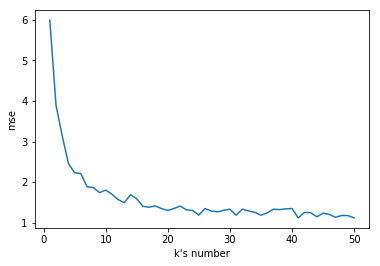

In [19]:
plt.plot(ks, mses)
plt.xlabel('k\'s number')
plt.ylabel('mse')

GuideLine to finish Q1:
1. Abstract the rating matrix, which is [user_id] * [movie_id], shape should be (100000, 3)
2. Build a utility Matrix, which contains $u_{ij}$ is the user i's rating for movie j, shape should be (943, 1682)
3. Build your own algorithms to calculate the similarity bewtween users, and get the user_sim matrix. You can define the user's similarity by different algorithm. In the end, you will have a user_sim matrix which is (943, 943).
Predict and evaluation:
1. Choose multiple users(says 100) from datasets randomly, then predict their ratings from the k-nn from user_sim's rating.(don't forget remove their own ratings), says y_pred, k is the hyperparameter.
2. Calculate the average RMSE between y_pred and their ratings.
3. Report the k and RMSE.

What will we check:
1. The plot of k's number and the RMSE
2. How did you define the similarity between users?
3. Which k will you choose for prediction?


### PROBLEM 3: Social Community Detection

In [20]:
def krodetla(x,y):
    if x == y: 
        return 1
    else:
        return 0

def adjancymatrix(edges):
    points = []
    for (x,y) in edges:
        points.append(x)
        points.append(y)
    points = set(points)
    A = np.zeros((len(points),len(points)))
    for edge in edges:
        startId = edge[0]
        endId = edge[1]
        startIdx = pointId2Index(startId)
        endIdx = pointId2Index(endId)
        A[startIdx][endIdx] = 1
        A[endIdx][startIdx] = 1
    return A

def modularity(edges):
    m = len(edges)
    A = adjancymatrix(edges)
    edges = np.array(edges) - 1
    if m == 0 : return 0
    
    
    
    return Q

In [21]:
edges = [
    (1,2),
    (1,3),
    (1,4),
    (1,5),
    (1,6),
    (1,11),
    (2,3),
    (2,4),
    (2,5),
    (3,4),
    (3,5),
    (4,5),
    (6,11),
    (6,7),
    (6,8),
    (6,9),
    (6,10),
    (7,8),
    (7,9),
    (7,10),
    (8,9),
    (8,10),
    (9,10),
    (11,12),
    (11,13),
    (11,15),
    (11,14),
    (12,13),
    (12,14),
    (12,15),
    (13,14),
    (13,15),
    (14,15)
]

membership = [0]*5 + [1] * 5 + [2] * 5

In [22]:
membership

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]

In [23]:
points = []
for (s,t) in edges:
    points.append(s)
    points.append(s)

In [24]:
G = nx.from_edgelist(edges, create_using= nx.Graph())

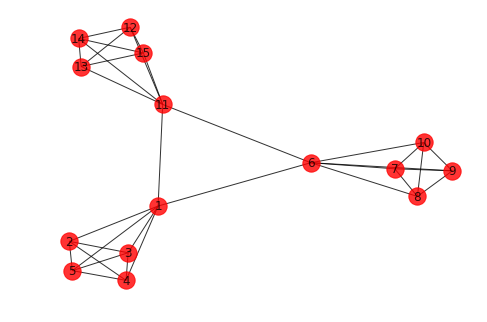

In [25]:
nx.draw(G,with_labels=True, alpha=0.8, node_color='red',)

In [26]:
points = []
for x,y in edges:
    points.append(x)
    points.append(y)
points = set(points)

In [27]:
g = igraph.Graph()
g.add_vertices(len(points))
g.add_edges(np.array(edges)-1)

[11.0,
 11.0,
 11.0,
 11.0,
 25.0,
 25.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 25.0,
 11.0,
 11.0,
 11.0,
 11.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 11.0,
 11.0,
 11.0,
 11.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

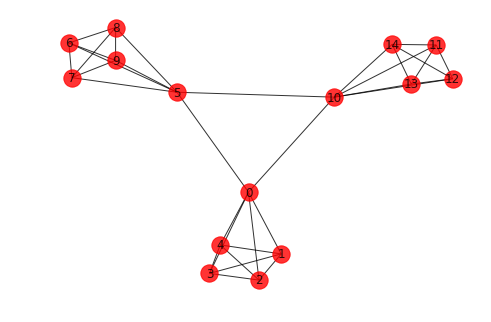

In [28]:
edges = []
for e in g.es:
    edges.append(e.tuple)
G = nx.from_edgelist(edges, create_using= nx.Graph())
nx.draw(G,with_labels=True, alpha=0.8, node_color='red',)
g.edge_betweenness()

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

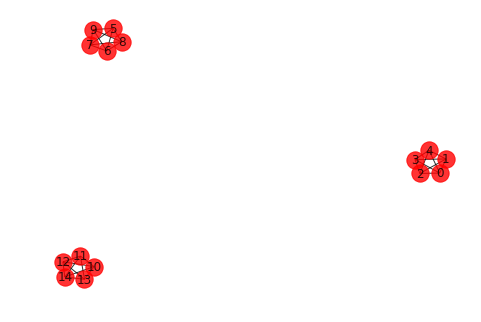

In [29]:
a = np.array(g.edge_betweenness())
g.delete_edges(np.argwhere(a == np.amax(a)).flatten())
edges = []
for e in g.es:
    edges.append(e.tuple)
G = nx.from_edgelist(edges, create_using= nx.Graph())
nx.draw(G,with_labels=True, alpha=0.8, node_color='red',)
g.edge_betweenness()